# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
  1
 -1
 -1
 -1
  1
  1
  1
  1
 -1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
 -1
  1
  1

### We create a function to visualize the data

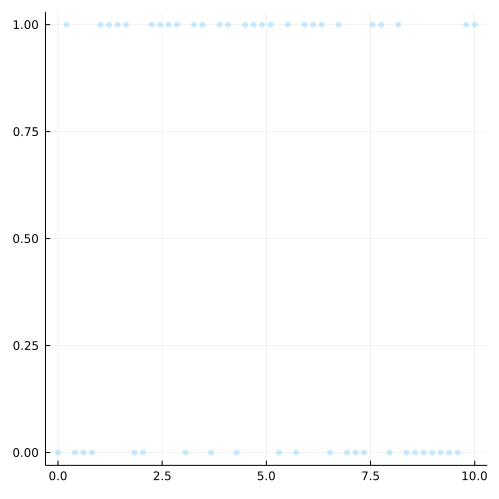

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.188731 seconds (1.82 M allocations: 103.801 MiB, 99.50% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.8159066260270287, 0.757245381353131, 0.6958377757529648, 0.6422590750792824, 0.6102400855147913, 0.6099515991447577, 0.6407184153213313, 0.6916088484586074, 0.7490149319122208, 0.8024108758474907  …  0.8881429992055638, 0.9695435655807071, 1.033357187282403, 1.064287458870773, 1.0524321143717343, 0.997665363353452, 0.9123705303382338, 0.821572968529659, 0.7574375068524904, 0.743709647374439], θ = [0.2369961636187935, 0.23870119538698792, 0.24037830968008175, 0.24174660188652428, 0.24252023162660363, 0.24252704857171875, 0.24178459305505104, 0.24048958867049852, 0.23893251291991682, 0.2373970246954867  …  0.2347671539101421, 0.23209736969997696, 0.22989750462120523, 0.22880005709360857, 0.22922301119771424, 0.23113893910690528, 0.23398936555848254, 0.23682636000486068, 0.23869577199135

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:45
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:25
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:16
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:42
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:21
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:07
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:58
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:50
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:40
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:36
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:33
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.14755356413693627, -0.12520905711349706, -0.4328273475378729, -0.751138984961913, -1.0364375547315472, -1.2548986876473982, -1.325051321806111, -1.2635653895172485, -1.065129460188189, -0.6765955810359953  …  -1.4124552147469425, -1.3990443128738856, -1.3476805960624367, -1.2592285625851867, -1.0978240990063242, -0.8728150226752847, -0.5986709452677723, -0.32121786226155424, -0.054689707072796634, 0.11066551670267433]]
 [[0.6716870424302579, 0.47623802505107193, 0.3190079336395847, 0.13045287069992395, -0.015404629471519885, -0.12534840902602976, -0.2074557672045104, -0.23734968046879185, -0.18693543854873135, -0.08899155389711644  …  -0.17495836655933616, -0.30832321184782874, -0.5222189568685709, -0.7442784256012195, -1.0067602447373356, -1.1425954469815502, -1.1649559761827937, -1.094815230079607, -0.9415389416145259, -0.74584241457471]]
 [[-1.4652440678851493, -1.3192499371828201, -0.9830654631863281, -0.468516121238739, 0.08400957

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

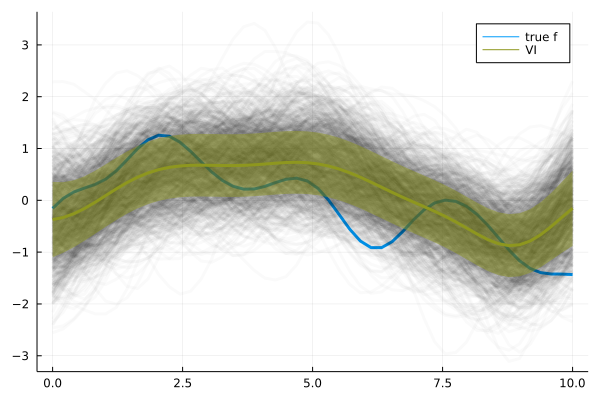

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

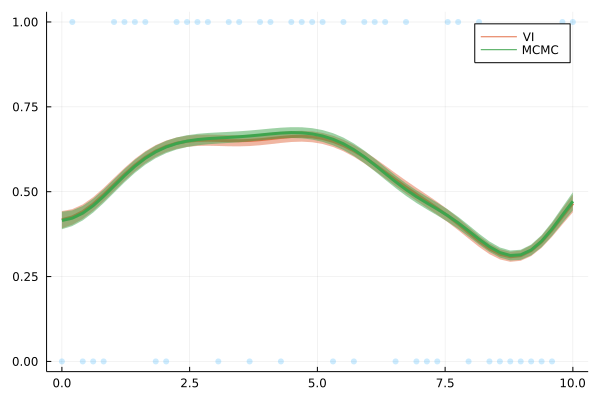

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*